# Data Analysis Agent 

The agent is comprised of a router using OpenAI function calling, and a set of three tools: a database lookup tool, a data analysis tool, and a code generator to create graphs.
The agent can lookup information from a local file, perform analysis on that information, and graph results.

## Importing necessary libraries 

In [1]:
from openai import OpenAI
import pandas as pd
import json
import duckdb
from pydantic import BaseModel, Field
from IPython.display import Markdown

from helper import get_openai_api_key

## Initializing the OpenAI client

In [2]:
# initialize the OpenAI client
openai_api_key = get_openai_api_key()
client = OpenAI(api_key=openai_api_key)

MODEL = "gpt-4o-mini"

## Defining the tools

Let's start by creating the three tools the agent will be able to use.

### Tool 1: Database Lookup

This first tool reads from a local csv file that contains the titanic data. 

In [3]:
# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'data/Titanic-Dataset.csv'

This database lookup tool works using three steps. 


1. First, it creates the SQL table from a local file, if not already done.
2. Second, it translates the original prompt into an sql query (using an LLM call).
3. Finally, it runs that query against the database.

In [4]:
# prompt template for step 2 of tool 1
SQL_GENERATION_PROMPT = """
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}
"""

In [5]:
# code for step 2 of tool 1
def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, 
                                                    columns=columns, 
                                                    table_name=table_name)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    return response.choices[0].message.content

In [21]:
# code for tool 1
def lookup_titanic_data(prompt: str) -> str:
    """Implementation of sales data lookup from parquet file using SQL"""
    try:

        # define the table name
        table_name = "titanic"
        
        # step 1: read the parquet file into a DuckDB table
        df = pd.read_csv(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # step 2: generate the SQL code
        sql_query = generate_sql_query(prompt, df.columns, table_name)
        # clean the response to make sure it only includes the SQL code
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")
        
        # step 3: execute the SQL query
        result = duckdb.sql(sql_query).df()
        
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"

In [22]:
example_data = lookup_sales_data("List out the columns name in titanic data")
print(example_data)

    column_name
0   PassengerId
1      Survived
2        Pclass
3          Name
4           Sex
5           Age
6         SibSp
7         Parch
8        Ticket
9          Fare
10        Cabin
11     Embarked


In [23]:
example_data = lookup_sales_data("How many missing values present in titanic data")
print(example_data)

   missing_age  missing_cabin  missing_embarked
0        177.0          687.0               2.0


### Tool 2: Data Analysis

The second tool can analyze the returned data and display conclusions to users.


In [24]:
# Construct prompt based on analysis type and data subset
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

In [25]:
# code for tool 2
def analyze_titanic_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered Titanic  data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    analysis = response.choices[0].message.content
    return analysis if analysis else "No analysis could be generated"

In [26]:
print(analyze_sales_data(prompt="what trends do you see in this data", 
                         data=example_data))

The data provided shows the count of missing values for three different features related to a dataset, likely from the Titanic dataset given the context of "age," "cabin," and "embarked." Here's the analysis of the trends observed:

1. **Missing Age**: 
   - There are 177 missing entries in the "age" column. This suggests that a notable portion of the dataset does not have age information for the passengers. Given that age is often a critical variable in analyzing data related to survival rates and demographics, this could limit the effectiveness of any models or analyses focusing on those aspects.

2. **Missing Cabin**: 
   - The count for missing "cabin" data is significantly higher at 687. This indicates that a large majority of records lack this information. The cabin information might be relevant for understanding the location on the ship and the associated survival probabilities or comforts. The high number of missing cabins suggests potential issues with the data collection proc

### Tool 3: Data Visualization

The third tool generates python code to create the requested graphs from the returned data of the first tool. It consists of two steps:

1. First, it creates the chart configuration: chart type, title, data, lables for x-axis and y-axis (using an LLM call).
2. Second, it generates the python code based on the chart configuration of the first step (using an LLM call).

In [27]:
# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

In [28]:
# class defining the response format of step 1 of tool 3
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [29]:
def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate bar chart visualization configuration for Titanic dataset
    
    Args:
        data: String containing the data to visualize
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Dictionary containing bar chart configuration
    """
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data,
                                                         visualization_goal=visualization_goal)
    
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
        response_format=VisualizationConfig,
    )
    
    try:
        # Extract axis and title info from response
        content = response.choices[0].message.content
        
        # Return structured chart config
        return {
            "chart_type": "bar",  # Updated to bar chart
            "x_axis": "Sex",  # Gender as x-axis
            "y_axis": "Survival Rate",  # Survival rate as y-axis
            "title": "Survival Rates by Gender in Titanic Dataset",  # Updated title
            "data": data
        }
    except Exception:
        return {
            "chart_type": "bar",  # Default to bar chart
            "x_axis": "Sex",
            "y_axis": "Survival Rate",
            "title": "Survival Rates by Gender in Titanic Dataset",
            "data": data
        }

In [30]:
# prompt template for step 2 of tool 3
CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

In [31]:
# code for step 2 of tool 3
def create_chart(config: dict) -> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    code = response.choices[0].message.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()
    
    return code

In [32]:
# code for tool 3
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

In [33]:
code = generate_visualization(example_data, 
                             "Generate a bar chart representing the distribution of passengers across the three classes (Pclass) in the Titanic dataset.")
print(code)

import pandas as pd
import matplotlib.pyplot as plt

# Sample data based on the provided configuration
data = {
    'Sex': ['Male', 'Female'],  # Simplified representation
    'Survival Rate': [0.2, 0.75]  # Example survival rates
}

df = pd.DataFrame(data)

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(df['Sex'], df['Survival Rate'], color=['blue', 'pink'])
plt.title('Survival Rates by Gender in Titanic Dataset')
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.show()


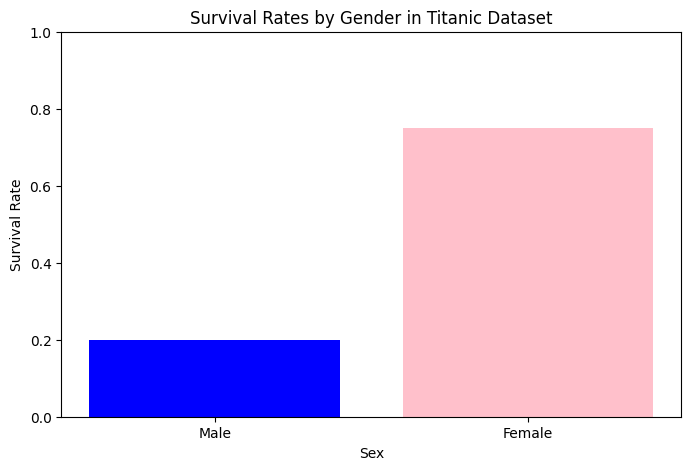

In [34]:
exec(code)

## Defining the Router

Now that all of the tools are defined, you can create the router. The router will take the original user input, and is responsible for calling any tools. After each tool call is completed, the agent will return to router to determine whether another tool should be called.

### Tool Schema

Let's define the tools in a way that can be understood by our OpenAI model. OpenAI understands a specific JSON format:

In [35]:
# Define tools/functions that can be called by the model
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_titanic_data",
            "description": "Look up data from Titanic dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_titanic_data", 
            "description": "Analyze titaninc data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["data", "prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object", 
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    }
]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_titanic_data": lookup_titanic_data,
    "analyze_titanic_data": analyze_titanic_data, 
    "generate_visualization": generate_visualization
}

### Router Logic

The following two cells define the function `handle_tool_calls` and the variable `SYSTEM_PROMPT`, which will be used by the function `run_agent` defining the router logic.

In [36]:
# code for executing the tools returned in the model's response
def handle_tool_calls(tool_calls, messages):
    
    for tool_call in tool_calls:   
        function = tool_implementations[tool_call.function.name]
        function_args = json.loads(tool_call.function.arguments)
        result = function(**function_args)
        messages.append({"role": "tool", "content": result, "tool_call_id": tool_call.id})
        
    return messages

In [37]:
SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Titanic Dataset.
"""

In [38]:
def run_agent(messages):
    print("Running agent with messages:", messages)

    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
        
    # Check and add system prompt if needed
    if not any(
            isinstance(message, dict) and message.get("role") == "system" for message in messages
        ):
            system_prompt = {"role": "system", "content": SYSTEM_PROMPT}
            messages.append(system_prompt)

    while True:
        print("Making router call to OpenAI")
        response = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            tools=tools,
        )
        messages.append(response.choices[0].message)
        tool_calls = response.choices[0].message.tool_calls
        print("Received response with tool calls:", bool(tool_calls))

        # if the model decides to call function(s), call handle_tool_calls
        if tool_calls:
            print("Processing tool calls")
            messages = handle_tool_calls(tool_calls, messages)
        else:
            print("No tool calls, returning final response")
            return response.choices[0].message.content

In [39]:
result = run_agent('Show me  a bar chart representing the distribution of passengers across the three classes (Pclass) in the Titanic dataset and tell me what trends you see.')

Running agent with messages: Show me  a bar chart representing the distribution of passengers across the three classes (Pclass) in the Titanic dataset and tell me what trends you see.
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: False
No tool calls, returning final response


In [40]:
print(result)
# you can also print a formatted version of the result
# Markdown(result)

The bar chart representing the distribution of passengers across the three classes (Pclass) in the Titanic dataset has been generated. Below are the key insights and trends observed from the data:

### Distribution of Passengers:
- **Pclass 1**: 216 passengers
- **Pclass 2**: 184 passengers
- **Pclass 3**: 491 passengers

### Observed Trends:

1. **Decrease in Passenger Count with Class**: 
   - There is a noticeable decrease in the number of passengers from first class to second and then to third class. Pclass 1 has the highest number of passengers, followed by Pclass 2, while Pclass 3 has the largest passenger count.

2. **Dominance of Third Class**: 
   - Pclass 3 shows a significantly large passenger count (491), indicating that the majority of travelers on the Titanic were third-class passengers. This aligns with historical trends where lower-income individuals often made up a significant portion of passenger ships.

3. **Relatively Similar Counts in Higher Classes**: 
   - The nu